In [12]:
import os
import numpy as np
import pandas as pd
from nilearn import datasets, image, masking, connectome
from nilearn.input_data import NiftiLabelsMasker
import matplotlib.pyplot as plt

In [18]:
# fp_connectivity shape: (n_subjects, n_frontal, n_parietal)
fp_connectivity = np.load("/home/nilayoh/frontoparietal_connectivity.npy")

In [19]:
n_subjects = fp_connectivity.shape[0]
X = fp_connectivity.reshape(n_subjects, -1)  # shape: (n_subjects, n_frontal * n_parietal)
print("Flattened shape for ML:", X.shape)

Flattened shape for ML: (68, 120)


In [21]:
import pandas as pd

# Load the label file
label_df = pd.read_csv("/home/nilayoh/groups.csv")  # update the path

# Preview
print(label_df.head())

        ID  age sex  KSADS_Hyp  KSADS_Inatt  KSADS_total_ADHD    group
0  sub-010   18   M          8            4                12     ADHD
1  sub-012   18   M          8            7                15     ADHD
2  sub-024   18   M          6            3                 9     ADHD
3  sub-055   22   M          9            6                15     ADHD
4  sub-061   25   M          0            0                 0  Control


In [22]:
data_ml = "/home/nilayoh/swm_fmri_data"  # change this to your actual path
subject_files = sorted([f for f in os.listdir(data_ml) if f.endswith('brain.nii.gz')])

In [24]:
import os
import pandas as pd
import numpy as np

# Path to your fMRI data
data_ml = "/home/nilayoh/swm_fmri_data"

# Get list of NIfTI files
subject_files = sorted([f for f in os.listdir(data_ml) if f.endswith("brain.nii.gz")])

# Extract subject IDs (e.g., "sub-010" from "sub-010_brain.nii.gz")
subject_ids_from_files = [f.split('_brain')[0] for f in subject_files]

# Load label CSV
pd.read_csv("/home/nilayoh/groups.csv")  # make sure filename is correct

subject_files = sorted([f for f in os.listdir(data_ml) if f.endswith("brain.nii.gz")])
subject_ids_from_files = [f.split('_')[0] for f in subject_files]

# Sort label_df by those subject IDs
label_df = label_df.set_index('ID').loc[subject_ids_from_files].reset_index()

# Confirm alignment
assert list(label_df['ID']) == subject_ids_from_files

# Extract labels
y = label_df['group'].values

In [25]:
print(label_df.columns)

Index(['ID', 'age', 'sex', 'KSADS_Hyp', 'KSADS_Inatt', 'KSADS_total_ADHD',
       'group'],
      dtype='object')


In [26]:
X = fp_connectivity.reshape(len(subject_files), -1)

In [29]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Create pipeline
pipeline = make_pipeline(StandardScaler(), SVC(kernel='linear'))

# Use Stratified K-Fold for balanced splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")

Cross-Validation Accuracy: 0.47 ± 0.13


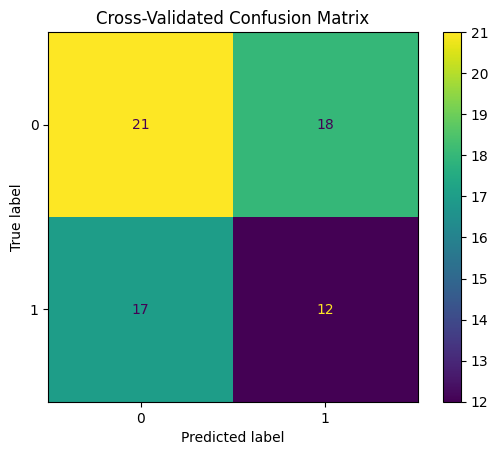

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(pipeline, X, y, cv=5)
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Cross-Validated Confusion Matrix")
plt.show()

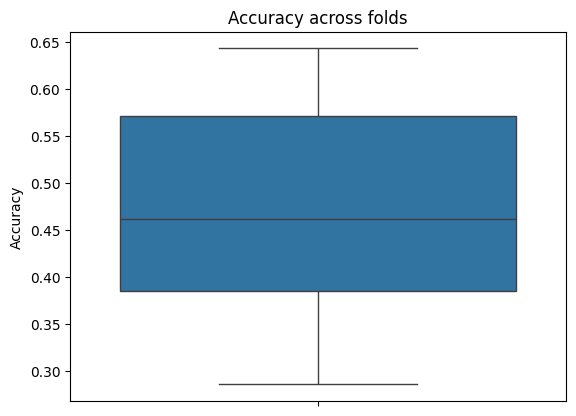

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `scores` contains the cross-validation results
sns.boxplot(data=scores)
plt.title("Accuracy across folds")
plt.ylabel("Accuracy")
plt.show()

In [26]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Fit encoder on training labels and transform
y_train_enc = le.fit_transform(y_train)

# Transform validation labels with the same encoder
y_val_enc = le.transform(y_test)

In [28]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svc = SVC(kernel='linear')

# Train
svc.fit(X_train, y_train_enc)

# Predict training and validation
y_train_pred = svc.predict(X_train)
y_val_pred = svc.predict(X_test)

# Calculate accuracy
train_acc = accuracy_score(y_train_enc, y_train_pred)
val_acc = accuracy_score(y_val_enc, y_val_pred)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")

Train Accuracy: 0.90
Validation Accuracy: 0.64


In [29]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svc, X_train, y_train_enc, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")

Cross-Validation Accuracy: 0.57 ± 0.06


In [31]:
pipeline = make_pipeline(StandardScaler(), SVC(kernel='linear'))

# Cross-validation with pipeline
scores = cross_val_score(pipeline, X_train, y_train_enc, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (with scaling): {scores.mean():.2f} ± {scores.std():.2f}")

# Train pipeline on all training data
pipeline.fit(X_train, y_train_enc)

# Predict validation
y_val_pred = pipeline.predict(X_test)
val_acc = accuracy_score(y_val_enc, y_val_pred)
print(f"Validation Accuracy (with scaling): {val_acc:.2f}")

Cross-Validation Accuracy (with scaling): 0.57 ± 0.10
Validation Accuracy (with scaling): 0.61


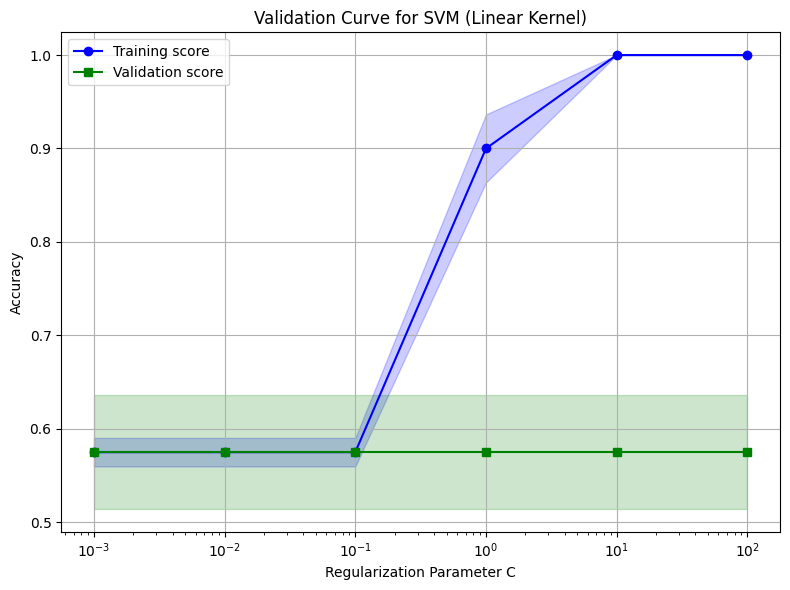

In [32]:
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

# Define a range of values for the hyperparameter C
param_range = np.logspace(-3, 2, 6)

# Compute training and validation scores using cross-validation
train_scores, val_scores = validation_curve(
    SVC(kernel="linear"), X_train, y_train_enc,
    param_name="C", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate the mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(param_range, train_mean, label="Training score", color="blue", marker='o')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)

plt.plot(param_range, val_mean, label="Validation score", color="green", marker='s')
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, color="green", alpha=0.2)

plt.xscale("log")
plt.xlabel("Regularization Parameter C")
plt.ylabel("Accuracy")
plt.title("Validation Curve for SVM (Linear Kernel)")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()